## Import the libraries

In [1]:
#importing the libraries
import tensorflow as tf  
from tensorflow import keras
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt 

## Load the data and data pre-processing

In [2]:
#load the extracted features
baseline_df = pd.read_excel('extracted_features_baseline.xlsx')
toolwear_df = pd.read_excel('extracted_features_toolwear.xlsx')

In [3]:
good_features = baseline_df.values
bad_features = toolwear_df.values

#train test split
from sklearn.model_selection import train_test_split
good_train, good_test = train_test_split(good_features, test_size=0.2, random_state=5)

bad_train, bad_test = train_test_split(bad_features, test_size=0.2, random_state=5)

In [5]:
#data scalling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
good_train = sc.fit_transform(good_train)
good_test = sc.transform(good_test)
bad_train = sc.fit_transform(bad_train)
bad_test = sc.transform(bad_test)

## Specifying the number of encoded features to be investigated

In [6]:
feature_size = [5, 10, 20, 40, 60]

## Train and Evaluate Autoencoders with different hidden layer size (encoded features)

In [7]:
result = []

# The number of encoded feature of autoencoder is varied in each iteration of the for loop 
for size in feature_size:
    
    condensed_f = size
    
    #constructing the good autoencoder model

    #input layer which number of neurons equals the number of original features
    l_in_good = keras.Input(good_features.shape[1])
    
    #hidden layer which condenses the feature into the specified number of condensed features
    l_condensed_good = keras.layers.Dense(condensed_f)(l_in_good)
    
    #output layer which is the same as the input
    l_out_good = keras.layers.Dense(good_features.shape[1])(l_condensed_good)


    #defining the good autoencoder
    autoencoder_good = keras.Model(l_in_good, l_out_good)

    #compile the model
    autoencoder_good.compile(optimizer='adam', loss='mse')
    #train the model
    autoencoder_good.fit(good_train, good_train, epochs = 50, batch_size = 8, validation_split = 0.1)


    
    #The autoencoders are asked to predict both classes of test data
    GAE_pred_good = autoencoder_good.predict(good_test)
    GAE_pred_bad = autoencoder_good.predict(bad_test)

    #The MSE of each entry in the entire dataset is stored in a temporary array
    #The 2 temporary arrays will be used to determine the margin between 2 classes (it needs all the values to find the minimum difference in MSE)
    GAE_MSE_bad = []
    GAE_MSE_good = []

    #The MSE of each entry in the test datasets are computed and stored in the temporary array
    for i in range(len(bad_test)):
        GAE_MSE_good.append(mean_absolute_error(good_test[i],GAE_pred_good[i]))
        GAE_MSE_bad.append(mean_absolute_error(bad_test[i],GAE_pred_bad[i]))

    #For each variation of window size, the margin between 2 classes will be stored in 'difference' array
    difference = []
    
    for x in range(1,20):
        window = x
        GAE_average_good = []
        GAE_average_bad = []
    
        for ind in range(len(GAE_MSE_good) - window + 1):
            GAE_average_good.append(np.mean(GAE_MSE_good[ind:ind+window]))
            GAE_average_bad.append(np.mean(GAE_MSE_bad[ind:ind+window]))

        #calculates the minimum difference in MSE between 2 classes and stores in the array
        difference.append(min(GAE_average_bad) - max(GAE_average_good))

    #The array 'difference' is obtained for each autoencoder with different number of encoded features. The entire array is appended into 'result' which is a 2-D array
    result.append(difference)




Epoch 1/50

38/38 [==============================] - 1s 7ms/step - loss: 1.1079 - val_loss: 1.0250
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 0.9638 - val_loss: 0.9201
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.8571 - val_loss: 0.8201
Epoch 4/50
38/38 [==============================] - 0s 3ms/step - loss: 0.7590 - val_loss: 0.7267
Epoch 5/50
38/38 [==============================] - 0s 3ms/step - loss: 0.6751 - val_loss: 0.6529
Epoch 6/50
38/38 [==============================] - 0s 2ms/step - loss: 0.6129 - val_loss: 0.6019
Epoch 7/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5667 - val_loss: 0.5653
Epoch 8/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5319 - val_loss: 0.5359
Epoch 9/50
38/38 [==============================] - 0s 2ms/step - loss: 0.5034 - val_loss: 0.5106
Epoch 10/50
38/38 [==============================] - 0s 2ms/step - loss: 0.4796 - val_loss: 0.4895
Epoch 11/50
38/3

([<matplotlib.axis.XTick at 0x22d091f3b90>,
 [Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18'),
  Text(20, 0, '20')])

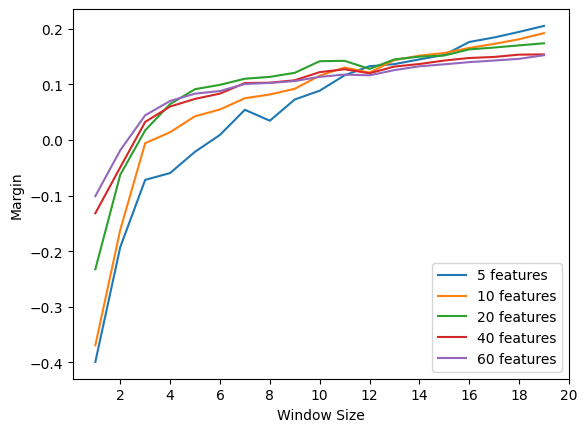

In [8]:
#plotting the result
window_sizes = list(range(1,len(result[0])+1))
plt.plot(window_sizes, result[0], label = "5 features") 
plt.plot(window_sizes, result[1], label = "10 features") 
plt.plot(window_sizes, result[2], label = "20 features") 
plt.plot(window_sizes, result[3], label = "40 features") 
plt.plot(window_sizes, result[4], label = "60 features") 
plt.xlabel("Window Size")
plt.ylabel("Margin")
plt.legend(loc='lower right') 
plt.xticks([2, 4, 6, 8, 10, 12, 14, 16, 18, 20])